In [1]:
import numpy as np
import pandas as pd

import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr

stock = pdr.get_data_yahoo('AAPL', start='2011-07-01', end = '2023-12-31')

[*********************100%%**********************]  1 of 1 completed


In [2]:
stock_show=stock

In [3]:
stock = stock.drop('Adj Close', axis=1)

In [4]:
stock.head()

,Open,High,Low,Close,Volume
Date,,,,,
2011-07-01,11.998214,12.267857,11.935714,12.259286,435313200
2011-07-05,12.250000,12.493929,12.232143,12.479643,355054000
2011-07-06,12.462500,12.646429,12.382500,12.562857,444626000
2011-07-07,12.666786,12.785714,12.642857,12.757143,399663600
2011-07-08,12.619286,12.857143,12.578571,12.846786,489633200


In [5]:
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3145 entries, 2011-07-01 to 2023-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3145 non-null   float64
 1   High    3145 non-null   float64
 2   Low     3145 non-null   float64
 3   Close   3145 non-null   float64
 4   Volume  3145 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 147.4 KB


In [6]:
stock.describe()

,Open,High,Low,Close,Volume
count,3145.000000,3145.000000,3145.000000,3145.000000,3.145000e+03
mean,65.833045,66.544798,65.156530,65.881246,2.052221e+08
std,55.717986,56.349366,55.138062,55.775793,1.837858e+08
min,11.998214,12.267857,11.935714,12.259286,2.404830e+07
25%,23.883572,24.142500,23.665358,23.888214,8.810510e+07
50%,39.152500,39.457500,38.762501,39.075001,1.347660e+08
75%,120.070000,121.480003,118.620003,120.089996,2.561160e+08
max,198.020004,199.619995,197.000000,198.110001,1.506120e+09


In [7]:
stock.to_csv('applekidetail.csv')

In [8]:
%matplotlib inline

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Volume'}>, <Axes: >]], dtype=object)

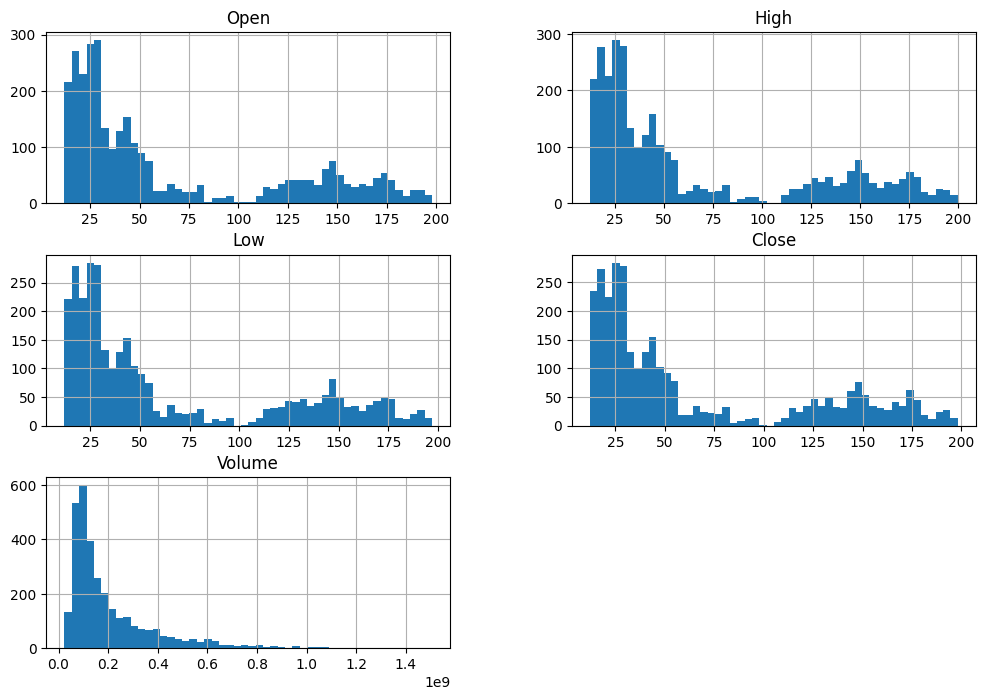

In [9]:
import matplotlib as plt
stock.hist(bins=50, figsize=(12,8))

## Train Test Splitting

In [10]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(stock, test_size=0.2, random_state=42)
print(f"Rows in train: {len(train_set)}\nRows in test : {len(test_set)}")

Rows in train: 2516
Rows in test : 629


In [11]:
stock = train_set.copy()

## Looking for correlation

In [12]:
corr_matrix = stock.corr()
corr_matrix['Close'].sort_values(ascending=False)

Close     1.000000
Low       0.999884
High      0.999869
Open      0.999734
Volume   -0.505695
Name: Close, dtype: float64

array([[<Axes: xlabel='High', ylabel='High'>,
        <Axes: xlabel='Low', ylabel='High'>],
       [<Axes: xlabel='High', ylabel='Low'>,
        <Axes: xlabel='Low', ylabel='Low'>]], dtype=object)

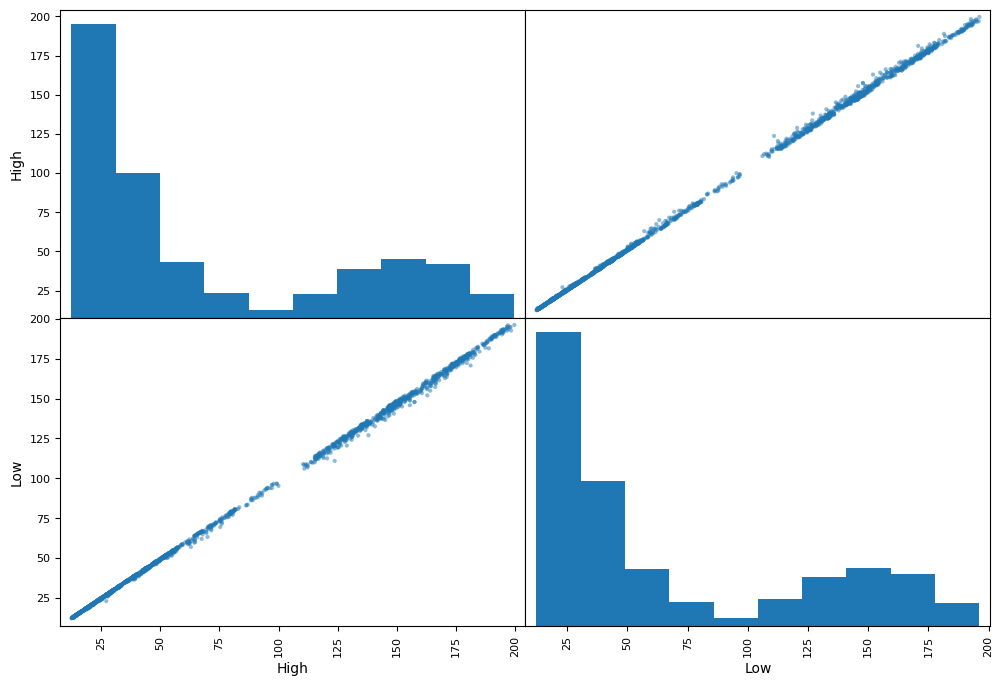

In [13]:
from pandas.plotting import scatter_matrix
attributes = ["High", "Low"]
scatter_matrix(stock[attributes], figsize=(12, 8))

## Trying out attributes

In [14]:
stock['OpenHigh']=stock['Open']/stock['High']

In [15]:
corr_matrix = stock.corr()
corr_matrix['Close'].sort_values(ascending=False)

Close       1.000000
Low         0.999884
High        0.999869
Open        0.999734
OpenHigh   -0.110672
Volume     -0.505695
Name: Close, dtype: float64

In [16]:
stock = train_set.drop('Close', axis=1)
stock_labels = train_set['Close'].copy()

## Pipeline

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [18]:
my_pipeline = Pipeline([
    ('stdscaler', StandardScaler())
])

In [19]:
stock.head()

,Open,High,Low,Volume
Date,,,,
2022-01-21,164.419998,166.330002,162.300003,122848900
2014-07-14,23.965000,24.222500,23.912500,171240000
2017-06-06,38.474998,38.952499,38.445000,106499600
2016-05-19,23.660000,23.660000,23.392500,121768400
2012-05-17,19.475357,19.553572,18.932858,717220000


In [20]:
stock_num_tr = my_pipeline.fit_transform(stock)

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression()
#model = DecisionTreeRegressor()
#model = RandomForestRegressor()

model.fit(stock_num_tr, stock_labels)

LinearRegression()

In [22]:
some_data = stock.iloc[:5]
some_labels = stock_labels.iloc[:5]

In [23]:
some_data

,Open,High,Low,Volume
Date,,,,
2022-01-21,164.419998,166.330002,162.300003,122848900
2014-07-14,23.965000,24.222500,23.912500,171240000
2017-06-06,38.474998,38.952499,38.445000,106499600
2016-05-19,23.660000,23.660000,23.392500,121768400
2012-05-17,19.475357,19.553572,18.932858,717220000


In [24]:
prepared_data = my_pipeline.transform(some_data)

In [25]:
model.predict(prepared_data)

array([164.25869488,  24.15232036,  38.86605069,  23.45487669,
        19.09443233])

## Evaluating

In [26]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, stock_num_tr, stock_labels, scoring='neg_mean_squared_error', cv = 10)
rmse_scores = np.sqrt(-scores)

In [27]:
def print_scores(scores):
    print('scores: ', scores)
    print('mean: ', scores.mean())
    print('Standard deviation: ', scores.std())

print_scores(rmse_scores)

scores:  [0.54527897 0.58313086 0.45600788 0.65351122 0.54612552 0.67776255
 0.60385686 0.58765355 0.56533671 0.45805818]
mean:  0.5676722305003915
Standard deviation:  0.06847707716026309


## Saving the Model

In [28]:
from joblib import dump, load
dump(model, "stock.joblib")

['stock.joblib']

## Testing the Model

In [29]:
from sklearn.metrics import mean_squared_error
x_test = test_set.drop("Close", axis=1)
y_test = test_set['Close'].copy()
x_test_prepared_data = my_pipeline.transform(x_test)
final = model.predict(x_test_prepared_data)
final_mse = mean_squared_error(y_test, final)
final_rmse = np.sqrt(final_mse)

In [30]:
prepared_data

array([[ 1.73023836,  1.73116974,  1.72263745, -0.43717311],
       [-0.76909664, -0.76871194, -0.76563293, -0.16810375],
       [-0.51089759, -0.50958941, -0.50433197, -0.52808024],
       [-0.77452398, -0.77860715, -0.77498278, -0.44318102],
       [-0.84898786, -0.85084531, -0.85516918,  2.86771259]])

## Using the model

In [31]:
features = np.array([[174.67,	177.08,	174.05,	56725400]])
df = pd.DataFrame(features, columns =['Open', 'High', 'Low', 'Volume'])
ig = my_pipeline.transform(df)
model.predict(ig)

array([176.18305926])

In [32]:
stock_labels.head()

Date
2022-01-21    162.410004
2014-07-14     24.112499
2017-06-06     38.612499
2016-05-19     23.549999
2012-05-17     18.932858
Name: Close, dtype: float64

In [33]:
train_set


,Open,High,Low,Close,Volume
Date,,,,,
2022-01-21,164.419998,166.330002,162.300003,162.410004,122848900
2014-07-14,23.965000,24.222500,23.912500,24.112499,171240000
2017-06-06,38.474998,38.952499,38.445000,38.612499,106499600
2016-05-19,23.660000,23.660000,23.392500,23.549999,121768400
2012-05-17,19.475357,19.553572,18.932858,18.932858,717220000
...,...,...,...,...,...
2023-10-16,176.750000,179.080002,176.509995,178.720001,52517000
2015-11-06,30.277500,30.452499,30.155001,30.264999,132169200
2015-12-29,26.740000,27.357500,26.715000,27.184999,123724800


In [34]:
import pickle

In [35]:
data = {"model": model}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(data, file)

In [36]:
with open('saved_steps.pkl', 'rb') as file:
    data = pickle.load(file)

regressor_loaded = data["model"]

In [37]:
x = my_pipeline.transform([[32.67, 32.74, 32.47, 123934000.00]])

E:\python\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [38]:
x

array([[-0.61419499, -0.61887648, -0.61176519, -0.43113962]])

In [39]:
enable_gui

NameError: name 'enable_gui' is not defined